## Summary

This python notebook uses the fancyimpute package to generate baseline models.
* Median impute
* KNN1
* KNN3
* KNN10
* MICE

## Load Data

In [18]:
import numpy as np
    
# Load data
train_data = np.genfromtxt('../data/all_samples_filtered_train.csv', delimiter=',')
entry_test_data = np.genfromtxt('../data/all_samples_filtered_entry_test.csv', delimiter=',')
instrument_test_data = np.genfromtxt('../data/all_samples_filtered_instrument_test.csv', delimiter=',')
train_data[train_data==0] = np.nan
train_data[train_data==-1] = 0

entry_test_data[entry_test_data==0] = np.nan
entry_test_data[entry_test_data==-1] = 0

instrument_test_data[instrument_test_data==0] = np.nan
instrument_test_data[instrument_test_data==-1] = 0

In [19]:
print(train_data.shape, entry_test_data.shape, instrument_test_data.shape)

# Remove all-missing rows
all_missing = np.where(np.all(np.isnan(train_data), axis=1))[0]
keep = list(set(range(train_data.shape[0]))-set(all_missing))
train_data = train_data[keep, :]
entry_test_data = entry_test_data[keep, :]
instrument_test_data = instrument_test_data[keep, :]

print(np.unique(train_data)[:10])
print(np.unique(entry_test_data)[:10])
print(np.unique(instrument_test_data)[:10])


(16291, 250) (16291, 250) (16291, 250)
[  0.   1.   2.   3.   4.  nan  nan  nan  nan  nan]
[  0.   1.   2.   3.   4.  nan  nan  nan  nan  nan]
[  0.   1.   2.   3.   4.  nan  nan  nan  nan  nan]


## Train Models

In [44]:
from fancyimpute import SimpleFill

# Median impute
X_filled_simple = SimpleFill(fill_method='median').complete(train_data)
np.savetxt('../data/simple_fill.csv', X_filled_simple, delimiter=',')

In [20]:
from fancyimpute import KNN
from sklearn import preprocessing

# KNN 1, 3, 10
#X_filled_knn1 = KNN(k=1).complete(train_data)
#np.savetxt('../data/knn1_fill.csv', X_filled_knn1, delimiter=',')

#X_filled_knn3 = KNN(k=3).complete(train_data)
#np.savetxt('../data/knn3_fill.csv', X_filled_knn3, delimiter=',')

#X_filled_knn10 = KNN(k=10).complete(train_data)
#np.savetxt('../data/knn10_fill.csv', X_filled_knn10, delimiter=',')

Using TensorFlow backend.
//anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[MICE] Completing matrix with shape (16267, 250)
[MICE] Starting imputation round 1/85, elapsed time 0.139
[MICE] Starting imputation round 2/85, elapsed time 36.697
[MICE] Starting imputation round 3/85, elapsed time 73.443
[MICE] Starting imputation round 4/85, elapsed time 109.013
[MICE] Starting imputation round 5/85, elapsed time 144.158
[MICE] Starting imputation round 6/85, elapsed time 180.332
[MICE] Starting imputation round 7/85, elapsed time 216.375
[MICE] Starting imputation round 8/85, elapsed time 251.941
[MICE] Starting imputation round 9/85, elapsed time 285.561
[MICE] Starting imputation round 10/85, elapsed time 319.996
[MICE] Starting imputation round 11/85, elapsed time 353.864
[MICE] Starting imputation round 12/85, elapsed time 388.036
[MICE] Starting imputation round 13/85, elapsed time 422.105
[MICE] Starting imputation round 14/85, elapsed time 456.725
[MICE] Starting imputation round 15/85, elapsed time 490.643
[MICE] Starting imputation round 16/85, elapsed t

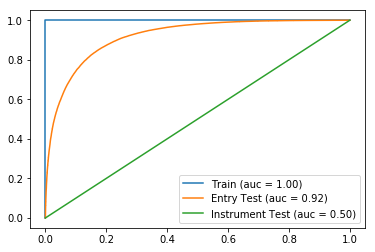

In [43]:
from fancyimpute import MICE
X_filled_mice = MICE(n_imputations=75, init_fill_method='median', min_value=0, max_value=4).complete(train_data)
np.savetxt('../data/mice_fill.csv', X_filled_mice, delimiter=',')

## Evaluate

In [16]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, roc_curve, auc
import matplotlib.pyplot as plt

m, n = train_data.shape

def evaluate(X_filled):
    
    X_filled_round = np.round(X_filled)
    X_filled_round[X_filled_round < 0] = 0
        
    for i in range(n):
        col_max = np.nanmax(train_data[:, i])
        X_filled_round[X_filled_round[:, i]>col_max] = col_max
        
    print(np.unique(X_filled_round))
    
    print('Train', cohen_kappa_score(train_data[~np.isnan(train_data)], X_filled_round[~np.isnan(train_data)], weights='linear'), 
          '\n', confusion_matrix(train_data[~np.isnan(train_data)], X_filled_round[~np.isnan(train_data)]))
    print('Entry test', cohen_kappa_score(entry_test_data[~np.isnan(entry_test_data)], X_filled_round[~np.isnan(entry_test_data)], weights='linear'), 
          '\n', confusion_matrix(entry_test_data[~np.isnan(entry_test_data)], X_filled_round[~np.isnan(entry_test_data)]))
    print('Instrument test', cohen_kappa_score(instrument_test_data[~np.isnan(instrument_test_data)], X_filled_round[~np.isnan(instrument_test_data)], weights='linear'),
          '\n', confusion_matrix(instrument_test_data[~np.isnan(instrument_test_data)], X_filled_round[~np.isnan(instrument_test_data)]))
    
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(train_data[~np.isnan(train_data)]>0, X_filled[~np.isnan(train_data)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Train (auc = %0.2f)' % roc_auc)
    
    fpr, tpr, _ = roc_curve(entry_test_data[~np.isnan(entry_test_data)]>0, X_filled[~np.isnan(entry_test_data)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Entry Test 0 (auc = %0.2f)' % roc_auc)
    
    fpr, tpr, _ = roc_curve(entry_test_data[~np.isnan(entry_test_data)]>1, X_filled[~np.isnan(entry_test_data)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Entry Test 1 (auc = %0.2f)' % roc_auc)
    
    fpr, tpr, _ = roc_curve(entry_test_data[~np.isnan(entry_test_data)]>2, X_filled[~np.isnan(entry_test_data)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Entry Test 2 (auc = %0.2f)' % roc_auc)
    
    fpr, tpr, _ = roc_curve(entry_test_data[~np.isnan(entry_test_data)]>3, X_filled[~np.isnan(entry_test_data)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Entry Test 3 (auc = %0.2f)' % roc_auc)

    plt.legend()
    
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(instrument_test_data[~np.isnan(instrument_test_data)]>0, X_filled[~np.isnan(instrument_test_data)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Instrument Test 0 (auc = %0.2f)' % roc_auc)
    
    fpr, tpr, _ = roc_curve(instrument_test_data[~np.isnan(instrument_test_data)]>1, X_filled[~np.isnan(instrument_test_data)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Instrument Test 1 (auc = %0.2f)' % roc_auc)
    
    fpr, tpr, _ = roc_curve(instrument_test_data[~np.isnan(instrument_test_data)]>2, X_filled[~np.isnan(instrument_test_data)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Instrument Test 2 (auc = %0.2f)' % roc_auc)
    
    fpr, tpr, _ = roc_curve(instrument_test_data[~np.isnan(instrument_test_data)]>3, X_filled[~np.isnan(instrument_test_data)])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Instrument Test 3 (auc = %0.2f)' % roc_auc)
    
    plt.legend()
    
    plt.show()

[ 0.  1.  2.  3.  4.]
Train 1.0 
 [[786464      0      0      0      0]
 [     0 456804      0      0      0]
 [     0      0 432949      0      0]
 [     0      0      0 196808      0]
 [     0      0      0      0    870]]
Entry test 0.302218349237 
 [[47935 32881  6692     0     0]
 [ 8722 33315  8708     0     0]
 [ 6987 26625 14282     0     0]
 [ 1633 11562  8742     0     0]
 [    0   102     0     0     0]]
Instrument test 0.323224317862 
 [[13020  7789  1468     0     0]
 [ 2285  9255  2408     0     0]
 [ 1917  7677  4127     0     0]
 [  404  3530  2724     0     0]
 [    0    22     0     0     0]]


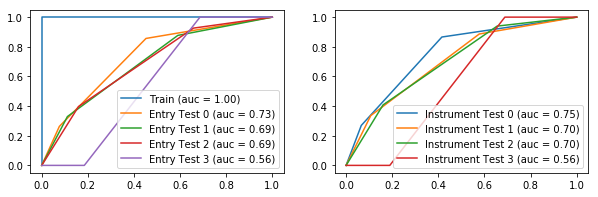

[ 0.  1.  2.  3.  4.]
Train 1.0 
 [[786464      0      0      0      0]
 [     0 456804      0      0      0]
 [     0      0 432949      0      0]
 [     0      0      0 196808      0]
 [     0      0      0      0    870]]
Entry test 0.505588791364 
 [[60466 22143  4468   348    83]
 [12147 27378 10325   844    51]
 [ 4867 18284 22488  2249     6]
 [  781  4450  9960  6737     9]
 [   13    17    21    30    21]]
Instrument test 0.253771365928 
 [[10454  8531  2804   482     6]
 [ 2878  7002  3590   472     6]
 [ 2198  6184  4671   667     1]
 [  606  2634  2718   699     1]
 [    0     1    11    10     0]]


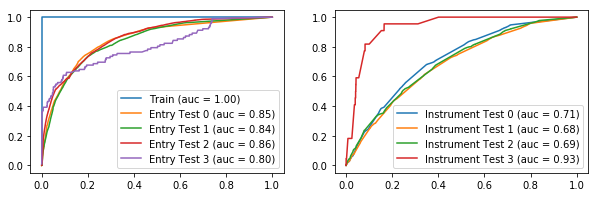

[ 0.  1.  2.  3.  4.]
Train 0.936578987116 
 [[748038   2493  35898     35      0]
 [     0 437194  19570     40      0]
 [     0   2502 430410     37      0]
 [     0   2416  29922 164470      0]
 [     0     57    487      0    326]]
Entry test 0.531860506971 
 [[49993 31659  5807    49     0]
 [ 3462 36529 10613   141     0]
 [  654 18812 27453   975     0]
 [   84  3036 14552  4265     0]
 [    0    13    70    19     0]]
Instrument test 0.351348778076 
 [[ 7433 12054  2777    13     0]
 [  543  8886  4476    43     0]
 [  284  5991  7275   171     0]
 [    5  1355  4880   418     0]
 [    0     2    19     1     0]]


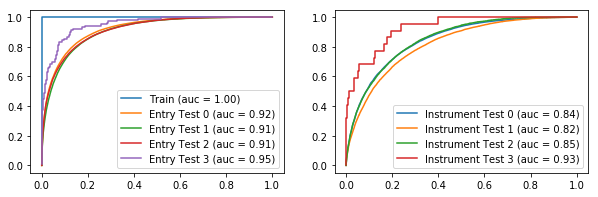

In [23]:
X_filled_simple = np.genfromtxt('../data/simple_fill.csv', delimiter=',')
X_filled_knn3 = np.genfromtxt('../data/knn3_fill.csv', delimiter=',')
X_filled_mice = np.genfromtxt('../data/mice_fill.csv', delimiter=',')

evaluate(X_filled_simple)
#evaluate(X_filled_knn)
evaluate(X_filled_knn3)
evaluate(X_filled_mice)

[ 0.  1.  2.  3.  4.]
Train 0.512782073114 
 [[568296 173399  42022   2747      0]
 [102521 245489 103427   5367      0]
 [ 53104 152639 208327  18874      5]
 [  8659  38184  96824  53075     66]
 [     8     49    187    447    179]]
Entry test 0.501913766184 
 [[62894 19390  4893   331     0]
 [11670 26655 11741   679     0]
 [ 6120 16858 22787  2129     0]
 [ 1096  4462 10607  5764     8]
 [    2    13    19    48    20]]
Instrument test 0.445276167853 
 [[15053  5267  1776   181     0]
 [ 2992  7022  3507   427     0]
 [ 2027  4975  5889   830     0]
 [  389  1521  3034  1713     1]
 [    0     2     7    11     2]]


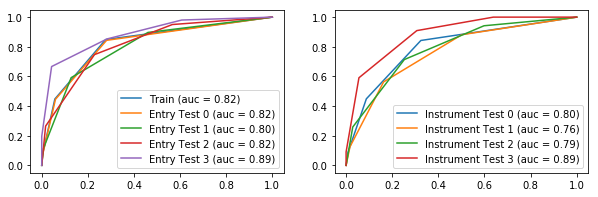

[ 0.  1.  2.  3.  4.]
Train 0.602513356449 
 [[605267 149358  29993   1846      0]
 [ 98476 257799  95516   5013      0]
 [ 34725 132499 242661  23064      0]
 [  4741  23566  91265  77155     81]
 [     1      9    110    495    255]]
Entry test 0.559047151297 
 [[65474 17290  4423   321     0]
 [11729 26844 11373   799     0]
 [ 4931 14950 25226  2786     1]
 [  850  3143  9962  7976     6]
 [    2     4    19    45    32]]
Instrument test 0.417988523115 
 [[14775  4810  2352   340     0]
 [ 3152  6356  3714   726     0]
 [ 2111  4620  5820  1170     0]
 [  435  1536  2876  1810     1]
 [    0     0    11     9     2]]


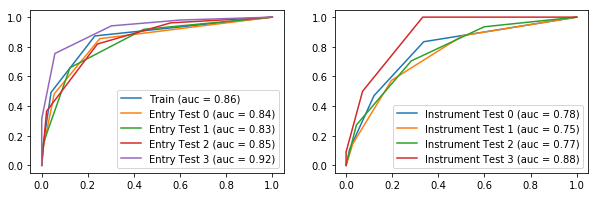

In [97]:
#evaluate(np.round(X_filled_mice))
k = 6
#Z = np.genfromtxt('../data/impute_bvs_Z%d.csv' % k, delimiter=',')
#glrm6 = Z[keep, :]-1
#evaluate(glrm6)

#Z = np.genfromtxt('../data/impute_bvs_noinit_Z%d.csv' % k, delimiter=',')
#glrm6 = Z[keep, :]-1
#evaluate(glrm6)

k=4
glrm_low = np.genfromtxt('../data/impute_bvs_simplex_offset_Z%d.csv' % k, delimiter=',')[keep, :]-1
evaluate(glrm_low)

k=12
glrm_high = np.genfromtxt('../data/impute_bvs_simplex_offset_Z%d.csv' % k, delimiter=',')[keep, :]-1
evaluate(glrm_high)

In [103]:
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

plotly.tools.set_credentials_file(username='snibbertort', api_key='IYxbf3vTNUhRHGoOCfAO')

conf = confusion_matrix(entry_test_data[~np.isnan(entry_test_data)], glrm_high[~np.isnan(entry_test_data)])

row_sums = conf.sum(axis=1)
weighted_conf = conf / row_sums[:, np.newaxis]

fig = ff.create_annotated_heatmap(weighted_conf[range(4, -1, -1), :], 
                                  #x=['Imputed<br>0', '1', '2', '3', '4'], 
                                  #y=['Actual<br>0', '1', '2', '3', '4'],
                                  annotation_text=conf[range(4, -1, -1), :],
                                 colorscale='Viridis')
py.iplot(fig, filename='annotated_heatmap')

In [96]:
conf = confusion_matrix(instrument_test_data[~np.isnan(instrument_test_data)], glrm_low[~np.isnan(instrument_test_data)])

row_sums = conf.sum(axis=1)
weighted_conf = conf / row_sums[:, np.newaxis]

fig = ff.create_annotated_heatmap(weighted_conf[range(4, -1, -1), :], 
                                  #x=['Imputed<br>0', '1', '2', '3', '4'], 
                                  #y=['Actual<br>0', '1', '2', '3', '4'],
                                  annotation_text=conf[range(4, -1, -1), :],
                                 colorscale='Viridis')
py.iplot(fig, filename='annotated_heatmap')

In [88]:
mice_round = np.round(X_filled_mice)
mice_round[mice_round < 0] = 0
        
for i in range(n):
    col_max = np.nanmax(train_data[:, i])
    mice_round[mice_round[:, i]>col_max] = col_max

In [93]:
conf = confusion_matrix(entry_test_data[~np.isnan(entry_test_data)], mice_round[~np.isnan(entry_test_data)])

row_sums = conf.sum(axis=1)
weighted_conf = conf / row_sums[:, np.newaxis]

fig = ff.create_annotated_heatmap(weighted_conf[range(4, -1, -1), :], 
                                  #x=['Imputed<br>0', '1', '2', '3', '4'], 
                                  #y=['Actual<br>0', '1', '2', '3', '4'],
                                  annotation_text=conf[range(4, -1, -1), :],
                                 colorscale='Viridis')
py.iplot(fig, filename='annotated_heatmap')

In [92]:
conf = confusion_matrix(instrument_test_data[~np.isnan(instrument_test_data)], mice_round[~np.isnan(instrument_test_data)])

row_sums = conf.sum(axis=1)
weighted_conf = conf / row_sums[:, np.newaxis]

fig = ff.create_annotated_heatmap(weighted_conf[range(4, -1, -1), :], 
                                  #x=['Imputed<br>0', '1', '2', '3', '4'], 
                                  #y=['Actual<br>0', '1', '2', '3', '4'],
                                  annotation_text=conf[range(4, -1, -1), :],
                                 colorscale='Viridis')
py.iplot(fig, filename='annotated_heatmap')